In [46]:
## @meermehran -- M3RG Lab -- Indian Institute of Technology, Delhi
## @date : 28Sept2022

####################################--DESCRIPTION####################################################
##                                                                                                 ##
## -----------------------------Benchmarking- FNO-v-ResNet-UNet----------------------------------- ##
##                                                                                                 ##        
#####################################################################################################

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from Adam import Adam
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
import scipy.io as sio

from timeit import default_timer
from utility import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
np.random.seed(0)


# STRAINS

#### Model 

In [2]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 
        self.fc0 = nn.Linear(3, self.width) 
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        
        return x   #[20,48,48,3]
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [17]:
######################################################
### Data Loading
######################################################


X_Data = '/DATA1/meer/data/material-v3-3350.mat'
Y_Data = '/DATA1/meer/data/strain-v3-3350.mat'


ntrain =1200
ntest = 200
batch_size =20
dim = 48
strain_channels = 3
modes = 12
width = 32
learning_rate = 0.001
epochs = 500
step_size = 80
gamma = 0.75


################################################################
# load data and data normalization
################################################################
reader = MatReader(X_Data)   
x_train = reader.read_field('Emat')[:ntrain]
x_test = reader.read_field('Emat')[-ntest:]
x_test_plot = reader.read_field('Emat')[-ntest:]

reader.load_file(Y_Data) 
y_train = reader.read_field('strain')[:ntrain]#   
y_test_strain = reader.read_field('strain')[-ntest:]   


######################################################
### Normalization
######################################################

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,dim,dim,1)
x_test = x_test.reshape(ntest,dim,dim,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_strain), batch_size=batch_size, shuffle=False)




In [18]:
print(f' x_train Shape := {x_train.shape}')
print(f' y_train Shape := {y_train.shape}')
print(f' x_test Shape := {x_test.shape}')
print(f' y_test_strain Shape := {y_test_strain.shape}')



 x_train Shape := torch.Size([1200, 48, 48, 1])
 y_train Shape := torch.Size([1200, 48, 48, 3])
 x_test Shape := torch.Size([200, 48, 48, 1])
 y_test_strain Shape := torch.Size([200, 48, 48, 3])


In [19]:

# ################################################################
## Model
# ################################################################
model = FNO2d(modes, modes, width).to(device)
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()

1188611


In [20]:

## ep wise error
trainerror=[] 
testerror=[]

##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,strain_channels)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x).reshape(batch_size, dim, dim,strain_channels)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 1  ||  TIME(sec):== 3.3157 || TrainError:== 0.526526  ||  TestError:== 0.377169
 Epoch :== 2  ||  TIME(sec):== 0.9273 || TrainError:== 0.322762  ||  TestError:== 0.279678
 Epoch :== 3  ||  TIME(sec):== 1.0052 || TrainError:== 0.251047  ||  TestError:== 0.232322
 Epoch :== 4  ||  TIME(sec):== 1.0805 || TrainError:== 0.218143  ||  TestError:== 0.208831
 Epoch :== 5  ||  TIME(sec):== 1.098 || TrainError:== 0.198247  ||  TestError:== 0.195459
 Epoch :== 6  ||  TIME(sec):== 1.1138 || TrainError:== 0.184442  ||  TestError:== 0.184594
 Epoch :== 7  ||  TIME(sec):== 1.0765 || TrainError:== 0.174827  ||  TestError:== 0.177758
 Epoch :== 8  ||  TIME(sec):== 1.0307 || TrainError:== 0.166908  ||  TestError:== 0.16968
 Epoch :== 9  ||  TIME(sec):== 1.0396 || TrainError:== 0.160436  ||  TestError:== 0.164688
 Epoch :== 10  ||  TIME(sec):== 1.0524 || TrainError:== 0.154699  ||  TestError:== 0.160578
 Epoch :== 11  ||  TIME(sec):== 1.0622 || TrainError:== 0.151216  ||  TestError:== 0.156269

In [6]:
# trainn = np.array(trainerror)
# testnn = np.array(testerror)
# torch.save(model.state_dict(),'FNO_STRAIN_N1200_ep500.pt')
# np.save('trainFNO_STRAIN', trainn)
# np.save('testFNO_STRAIN', testnn)

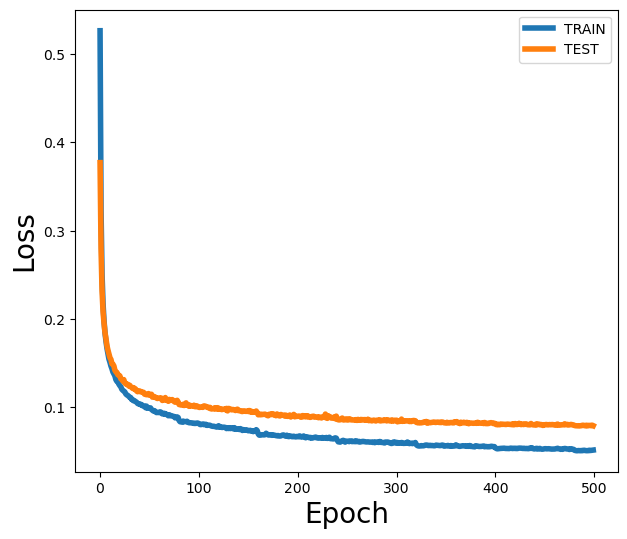

In [29]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror,linewidth = 4,label ="TRAIN")
plt.plot(range(epochs),testerror, linewidth = 4,label ="TEST")
plt.xlabel('Epoch', fontsize =20)
plt.ylabel('Loss', fontsize =20)
plt.legend()
plt.show()

## Testing 

In [14]:
# path = 'FNO_STRAIN_N1200_ep500.pt'
# model.load_state_dict(torch.load(path))
# print(model)


FNO2d(
  (fc0): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (w0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


#### Testing--Strains

In [30]:
prediction = torch.zeros(y_test_strain.shape)
c = 0
model.eval()
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x).reshape(batch_size, dim, dim,strain_channels)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

In [31]:
print(x_test_plot.shape, y_test_strain.shape, prediction.shape)

torch.Size([200, 48, 48]) torch.Size([200, 48, 48, 3]) torch.Size([200, 48, 48, 3])


In [32]:
strain_act = y_test_strain.reshape(ntest, -1)
strain_pred = prediction.reshape(ntest,-1)



In [33]:
r2_strain =[]   ## R2 for every sample [1,48,48,3
for i in range(strain_act.shape[0]):
    act = strain_act[i]
    pred = strain_pred[i]
    r2 = r2_score(act,pred)
    r2_strain += [r2]

In [34]:
r2_avg_strain = np.average(r2_strain)
r2_std_strain = np.std(r2_strain)

print(r2_avg_strain,r2_std_strain)

0.9887908570324003 0.0300387711493383


### METRIC Evaluation

In [35]:
print(np.round((r2_avg_strain),2))
print(np.round((r2_std_strain),2))

0.99
0.03


In [36]:
### Total loss on test set

loss = lossfunc(y_test_strain, prediction)
print(loss/ntest)

tensor(0.0793)


# STRESSES


#### Model

In [3]:
######################################################
### Data Loading & Hyperparameters
######################################################


X_Data = '/DATA1/meer/data/material-v3-3350.mat'
Y_Data = '/DATA1/meer/data/stress-v3-3350.mat'


ntrain =1200
ntest = 200
batch_size = 20
dim = 48
stress_channels = 3
modes = 12
width = 32
learning_rate = 0.001
epochs = 500
step_size = 80
gamma = 0.75


################################################################
# load data and data normalization
################################################################
reader = MatReader(X_Data)   
x_train = reader.read_field('Emat')[:ntrain]
x_test = reader.read_field('Emat')[-ntest:]
x_test_plot = reader.read_field('Emat')[-ntest:]

reader.load_file(Y_Data) 
y_train = reader.read_field('stress')[:ntrain]#   
y_test_stress = reader.read_field('stress')[-ntest:]   


######################################################
### Normalization
######################################################

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

x_train = x_train.reshape(ntrain,dim,dim,1)
x_test = x_test.reshape(ntest,dim,dim,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_stress), batch_size=batch_size, shuffle=False)




In [4]:
print(f' x_train Shape := {x_train.shape}')
print(f' y_train Shape := {y_train.shape}')
print(f' x_test Shape := {x_test.shape}')
print(f' y_test_stress Shape := {y_test_stress.shape}')


 x_train Shape := torch.Size([1200, 48, 48, 1])
 y_train Shape := torch.Size([1200, 48, 48, 3])
 x_test Shape := torch.Size([200, 48, 48, 1])
 y_test_stress Shape := torch.Size([200, 48, 48, 3])


In [5]:

# ################################################################
## Model
# ################################################################
model = FNO2d(modes, modes, width).to(device)
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()

1188611


In [6]:


## ep wise error
trainerror=[] 
testerror=[]

##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,stress_channels)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x).reshape(batch_size, dim, dim,stress_channels)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 1  ||  TIME(sec):== 3.5075 || TrainError:== 0.412682  ||  TestError:== 0.32846
 Epoch :== 2  ||  TIME(sec):== 1.0269 || TrainError:== 0.284131  ||  TestError:== 0.255965
 Epoch :== 3  ||  TIME(sec):== 0.9869 || TrainError:== 0.235074  ||  TestError:== 0.221014
 Epoch :== 4  ||  TIME(sec):== 0.9851 || TrainError:== 0.210187  ||  TestError:== 0.204152
 Epoch :== 5  ||  TIME(sec):== 0.9883 || TrainError:== 0.193079  ||  TestError:== 0.192052
 Epoch :== 6  ||  TIME(sec):== 0.9756 || TrainError:== 0.181704  ||  TestError:== 0.182381
 Epoch :== 7  ||  TIME(sec):== 0.8604 || TrainError:== 0.17328  ||  TestError:== 0.176395
 Epoch :== 8  ||  TIME(sec):== 0.8599 || TrainError:== 0.164582  ||  TestError:== 0.169278
 Epoch :== 9  ||  TIME(sec):== 0.8991 || TrainError:== 0.157321  ||  TestError:== 0.163621
 Epoch :== 10  ||  TIME(sec):== 0.9028 || TrainError:== 0.151607  ||  TestError:== 0.161623
 Epoch :== 11  ||  TIME(sec):== 0.9024 || TrainError:== 0.148934  ||  TestError:== 0.157802

In [16]:
# trainn = np.array(trainerror)
# testnn = np.array(testerror)
# torch.save(model.state_dict(),'FNO_STRESS_N1200_ep500.pt')
# np.save('trainFNOStress', trainn)
# np.save('testFNOStress', testnn)

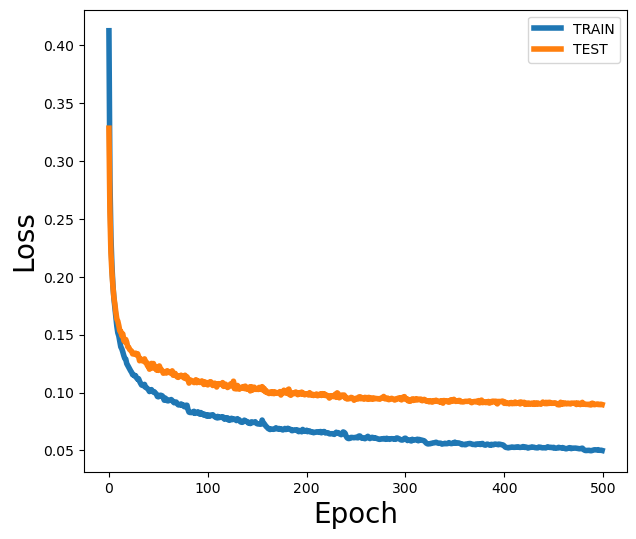

In [7]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror,linewidth = 4,label ="TRAIN")
plt.plot(range(epochs),testerror, linewidth = 4,label ="TEST")
plt.xlabel('Epoch', fontsize =20)
plt.ylabel('Loss', fontsize =20)
plt.legend()
plt.show()

In [41]:
# path = 'FNO_STRESS_N1200_ep500.pt'
# model.load_state_dict(torch.load(path))
# print(model)

FNO2d(
  (fc0): Linear(in_features=3, out_features=32, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (w0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


### Testing -- Stresses

In [8]:
prediction = torch.zeros(y_test_stress.shape)
c = 0
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x).reshape(batch_size, dim, dim,stress_channels)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

In [9]:
stress_act = y_test_stress.reshape(ntest, -1)
stress_pred = prediction.reshape(ntest,-1)

r2_stress =[]
for i in range(stress_act.shape[0]):
    act = stress_act[i]
    pred = stress_pred[i]
    r2 = r2_score(act,pred)
    r2_stress += [r2]

In [10]:
r2_avg_stress = np.average(r2_stress)
r2_std_stress = np.std(r2_stress)

print(r2_avg_stress,r2_std_stress)

0.9764350534419417 0.06692226983719535


#### R2 mean and std


In [11]:
print(np.round((r2_avg_stress),2))
print(np.round((r2_std_stress),2))

0.98
0.07


#### Total TestLoss

In [12]:
loss = lossfunc(y_test_stress, prediction)
print(loss/ntest)

tensor(0.0896)
